# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

2023-11-01 00:07:29.509957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 00:07:29.546845: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 00:07:29.547489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 00:07:30.073152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/john/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data loading

In [3]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels
  
mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

2023-11-01 00:07:30.983937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-01 00:07:30.984186: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Model creation

In [4]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()
# your code start from here for step 2

# 3x3 convolution
cnn_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
# 2x2 spatial pool
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# another convolution
cnn_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
# another pool
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# flatten
cnn_model.add(tf.keras.layers.Flatten())
# dropout
cnn_model.add(tf.keras.layers.Dropout(0.5))
# fully connected
cnn_model.add(tf.keras.layers.Dense(128, activation="relu"))
# dropout again
cnn_model.add(tf.keras.layers.Dropout(0.5))
# fully connected to 10 outputs
cnn_model.add(tf.keras.layers.Dense(10)) # no activation (logit output)

# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(tf.keras.layers.Flatten())
fc_model.add(tf.keras.layers.Dense(784, activation="relu"))
fc_model.add(tf.keras.layers.Dense(784, activation="relu"))
fc_model.add(tf.keras.layers.Dense(10)) # no activation (logit output)


# Teacher loss function

In [5]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)
  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3

  # as seen in the assignment below, tensorflow has a dedicated function for this
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))
  return cross_entropy_loss_value

# Student loss function

In [6]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_ORIGINAL = 4
DISTILLATION_TEMPERATURE = DISTILLATION_TEMPERATURE_ORIGINAL #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
  # your code start from here for step 3

  # soften the teacher's logits

  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return distillation_loss_value * ALPHA + cross_entropy_loss_value * (1 - ALPHA)

# Train and evaluation

In [7]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.int32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = tf.constant(0, dtype=tf.int32)
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += tf.reduce_sum(compute_num_correct(model, images, labels)[0])
    
    last_accuracy = num_correct / num_total * 100
    print("Class_accuracy: " + '{:.2f}%'.format(last_accuracy))
  return last_accuracy


# Training models

In [8]:
# your code start from here for step 5 
drop = train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 97.55%
Epoch 2: Class_accuracy: 98.40%
Epoch 3: Class_accuracy: 98.71%
Epoch 4: Class_accuracy: 98.81%
Epoch 5: Class_accuracy: 98.89%
Epoch 6: Class_accuracy: 99.01%
Epoch 7: Class_accuracy: 99.03%
Epoch 8: Class_accuracy: 99.15%
Epoch 9: Class_accuracy: 99.13%
Epoch 10: Class_accuracy: 99.15%
Epoch 11: Class_accuracy: 99.22%
Epoch 12: Class_accuracy: 99.22%


In [9]:
import time

start = time.time()
cnn_model(tf.zeros([1, 28, 28, 1], dtype=tf.float32), training=False)
end = time.time()
print(end - start)

0.008695602416992188


In [10]:
drop = train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.91%
Epoch 2: Class_accuracy: 97.90%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.49%
Epoch 5: Class_accuracy: 98.70%
Epoch 6: Class_accuracy: 98.77%
Epoch 7: Class_accuracy: 98.83%
Epoch 8: Class_accuracy: 98.91%
Epoch 9: Class_accuracy: 98.87%
Epoch 10: Class_accuracy: 98.87%
Epoch 11: Class_accuracy: 98.93%
Epoch 12: Class_accuracy: 98.84%


In [11]:
import time

start = time.time()
fc_model(tf.zeros([1, 28, 28, 1], dtype=tf.float32), training=False)
end = time.time()
print(end - start)

0.0031173229217529297


# Test accuracy vs. tempreture curve

Epoch 1: Class_accuracy: 98.47%
Epoch 2: Class_accuracy: 98.80%
Epoch 3: Class_accuracy: 98.79%
Epoch 4: Class_accuracy: 98.67%
Epoch 5: Class_accuracy: 98.64%
Epoch 6: Class_accuracy: 98.55%
Epoch 7: Class_accuracy: 98.79%
Epoch 8: Class_accuracy: 98.81%
Epoch 9: Class_accuracy: 98.75%
Epoch 10: Class_accuracy: 98.70%
Epoch 11: Class_accuracy: 98.74%
Epoch 12: Class_accuracy: 98.55%
Epoch 1: Class_accuracy: 98.93%
Epoch 2: Class_accuracy: 98.95%
Epoch 3: Class_accuracy: 98.91%
Epoch 4: Class_accuracy: 98.87%
Epoch 5: Class_accuracy: 98.76%
Epoch 6: Class_accuracy: 98.94%
Epoch 7: Class_accuracy: 99.02%
Epoch 8: Class_accuracy: 98.86%
Epoch 9: Class_accuracy: 98.92%
Epoch 10: Class_accuracy: 98.98%
Epoch 11: Class_accuracy: 98.90%
Epoch 12: Class_accuracy: 98.91%
Epoch 1: Class_accuracy: 99.01%
Epoch 2: Class_accuracy: 99.03%
Epoch 3: Class_accuracy: 99.10%
Epoch 4: Class_accuracy: 99.04%
Epoch 5: Class_accuracy: 99.06%
Epoch 6: Class_accuracy: 99.10%
Epoch 7: Class_accuracy: 99.11%
Ep

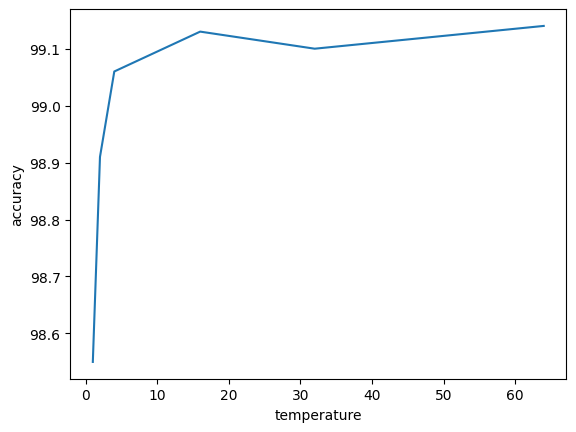

In [12]:
# your code start from here for step 6

import matplotlib.pyplot as plt

temperatures = [1,2,4,16,32,64]
outputs = []

for temp in temperatures:
    DISTILLATION_TEMPERATURE = temp
    acc = train_and_evaluate(fc_model, compute_student_loss)
    outputs.append(acc)

DISTILLATION_TEMPERATURE = DISTILLATION_TEMPERATURE_ORIGINAL # reset

plt.plot(temperatures, outputs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

# Train student from scratch

In [13]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.models.clone_model(fc_model) # checked online. this does not copy the weights. fresh start

# your code start from here for step 7

#@test {"output": "ignore"}
def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))
  return cross_entropy_loss_value

drop = train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: 

Class_accuracy: 96.87%
Epoch 2: Class_accuracy: 97.70%
Epoch 3: Class_accuracy: 97.73%
Epoch 4: Class_accuracy: 97.81%
Epoch 5: Class_accuracy: 98.25%
Epoch 6: Class_accuracy: 98.06%
Epoch 7: Class_accuracy: 98.32%
Epoch 8: Class_accuracy: 98.15%
Epoch 9: Class_accuracy: 98.35%
Epoch 10: Class_accuracy: 97.81%
Epoch 11: Class_accuracy: 98.01%
Epoch 12: Class_accuracy: 98.09%


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [14]:
# your code start from here for step 8

from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
    # had difficulty with the keras-flops package. used this instead.
    # from https://github.com/tensorflow/tensorflow/issues/32809#issuecomment-849439287
    forward_pass = tf.function(
        model.call,
        input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

    graph_info = profile(forward_pass.get_concrete_function().graph,
                            options=ProfileOptionBuilder.float_operation())
    flops = graph_info.total_float_ops // 2
    return flops

def get_num_params(model):
    return model.count_params()

print("teacher params: ", get_num_params(cnn_model))
print("teacher flops:  ", get_flops(cnn_model))
print("student params: ", get_num_params(fc_model))
print("student flops:  ", get_flops(fc_model))

teacher params:  225034
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


teacher flops:  
=========================Options=============================
 2659813
student params:  1238730
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read

# Implementing the state-of-the-art KD algorithm

In [15]:
# your code start from here for step 12

# Please see subclass_distillation.ipynb

# XAI method to explain models

===============================Teacher=================================


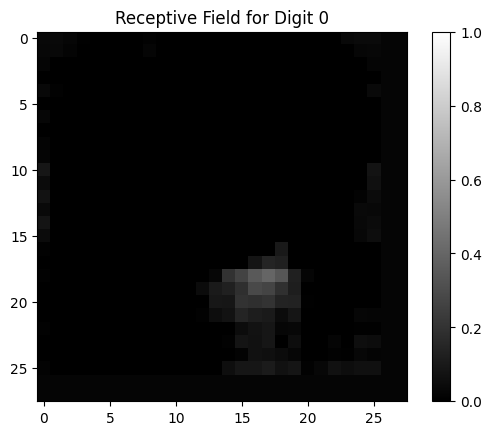

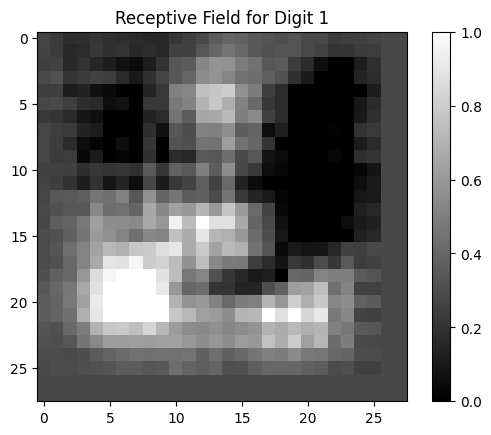

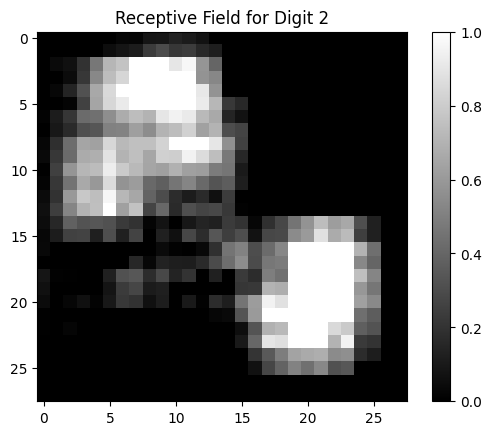

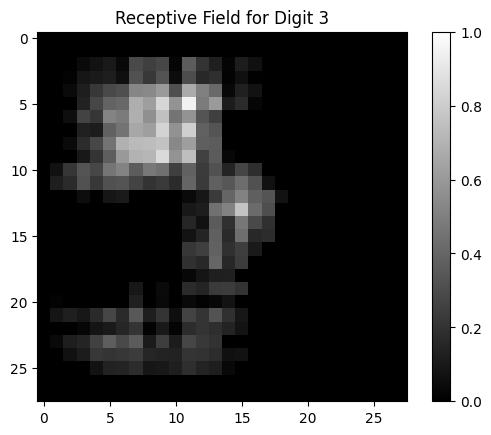

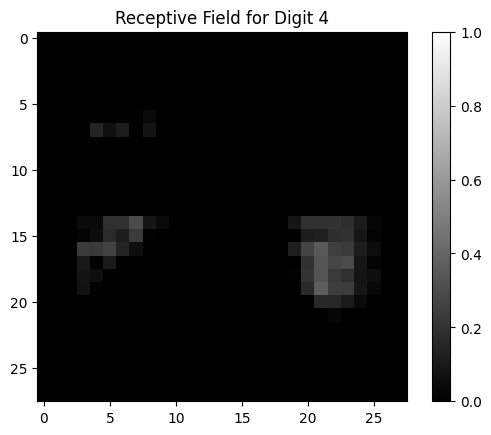

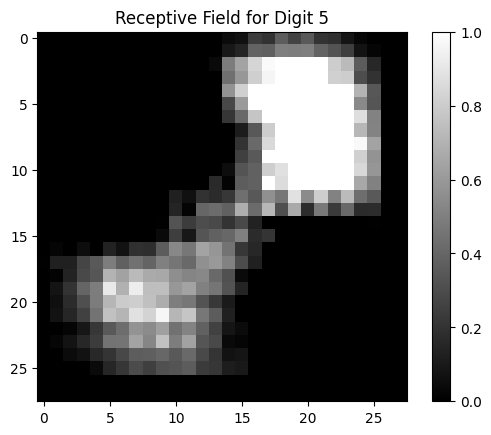

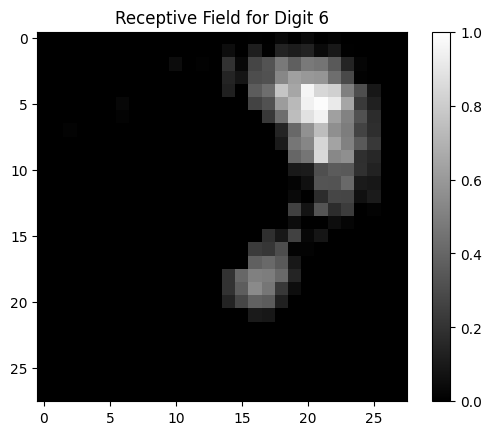

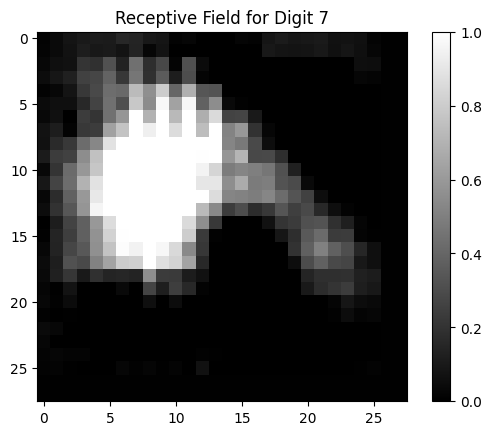

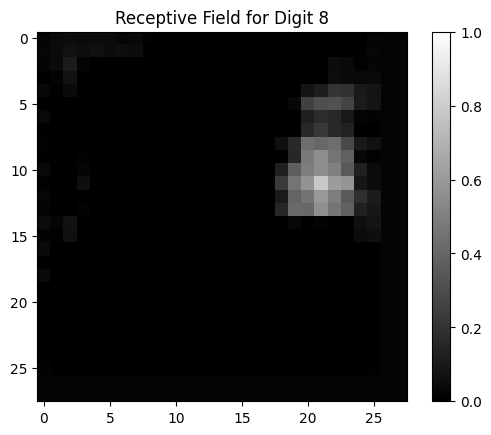

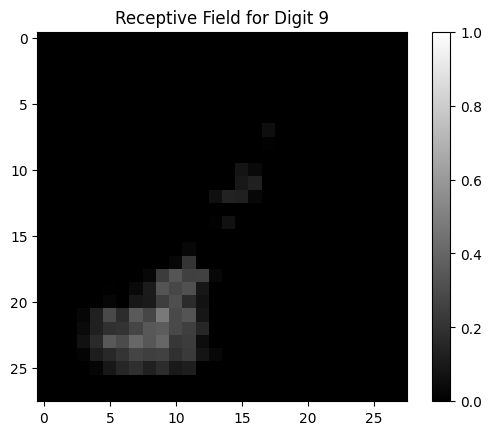

===============================Student=================================


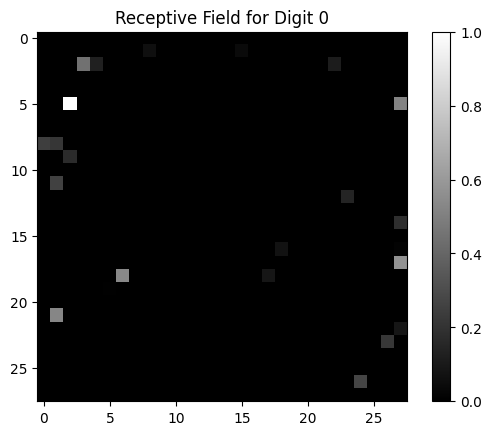

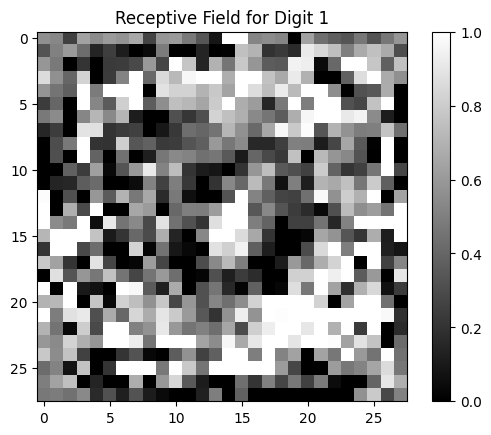

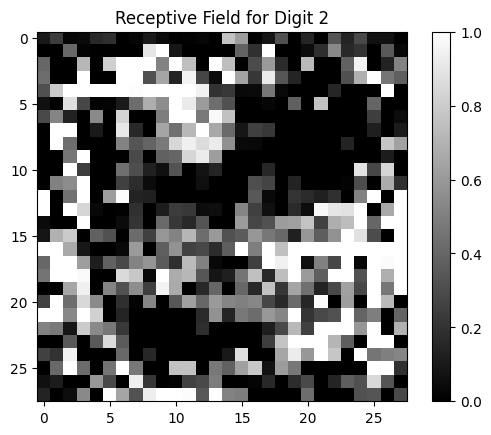

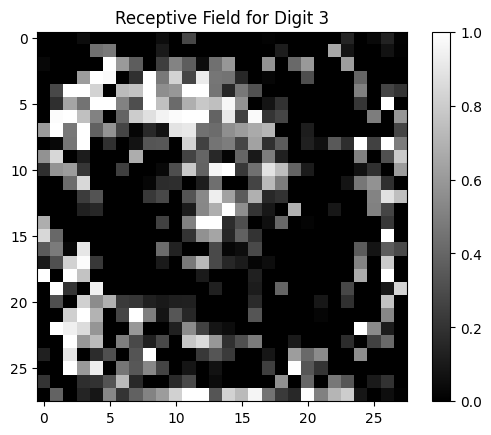

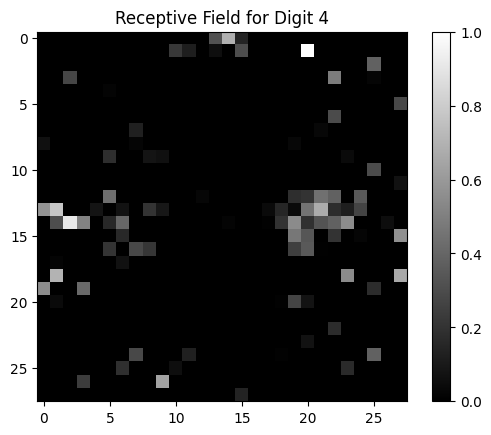

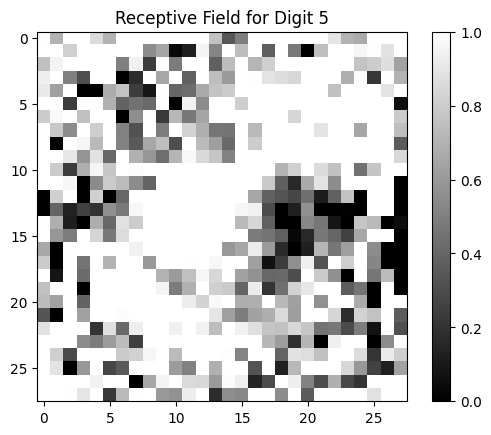

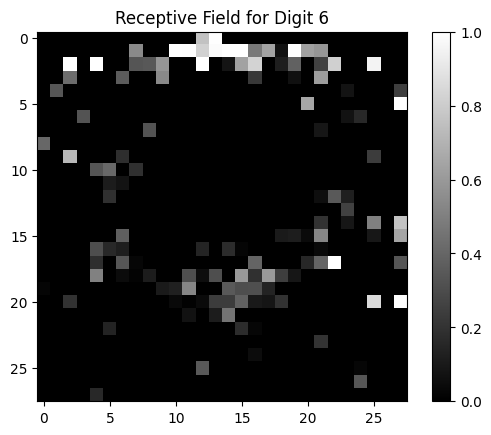

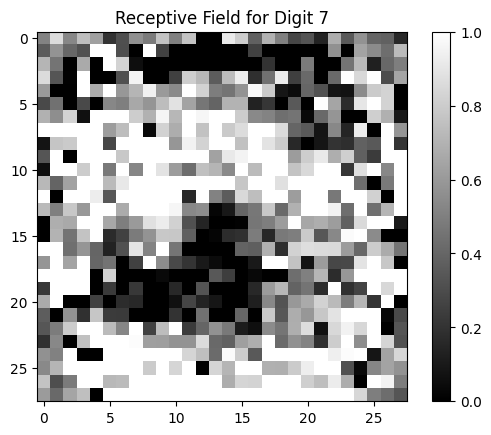

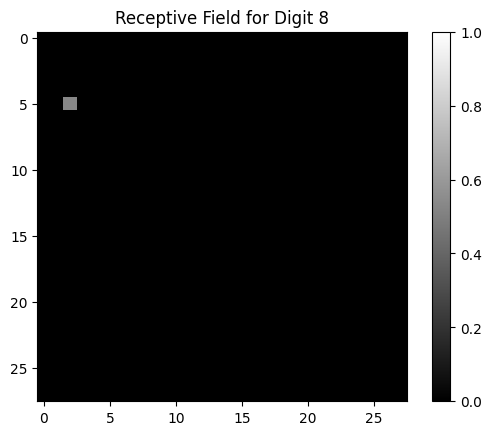

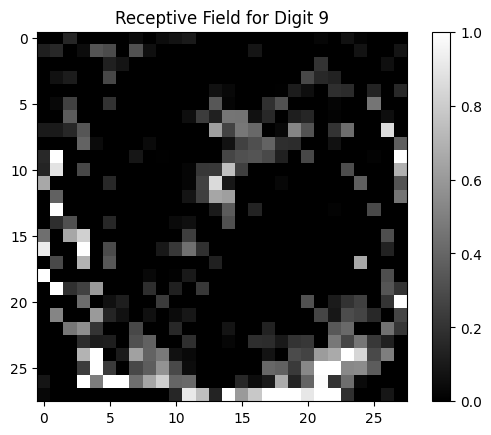

===============================Student Without Distillation=================================


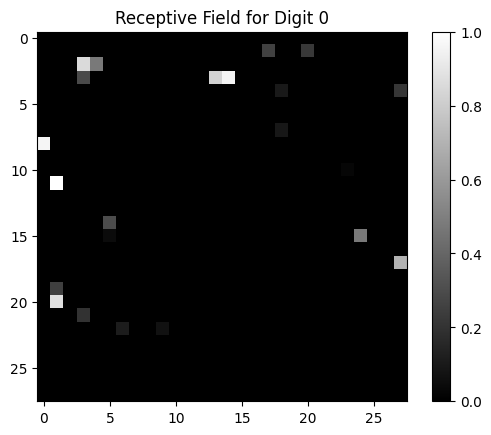

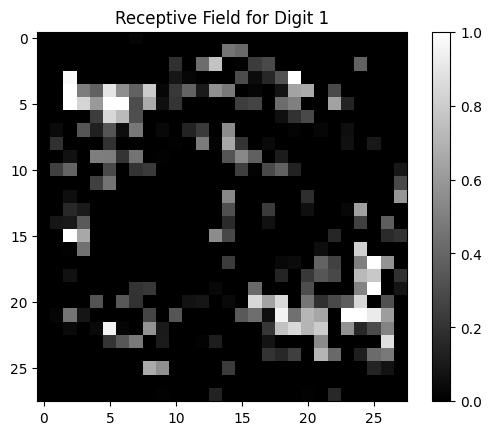

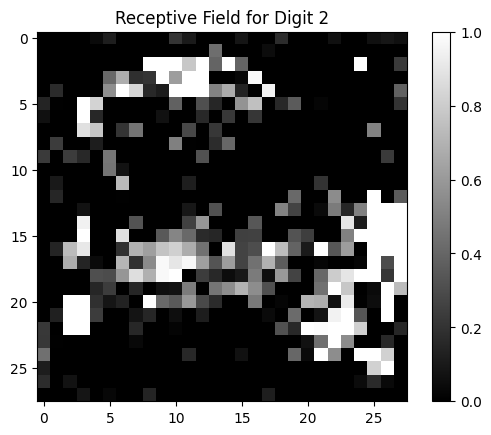

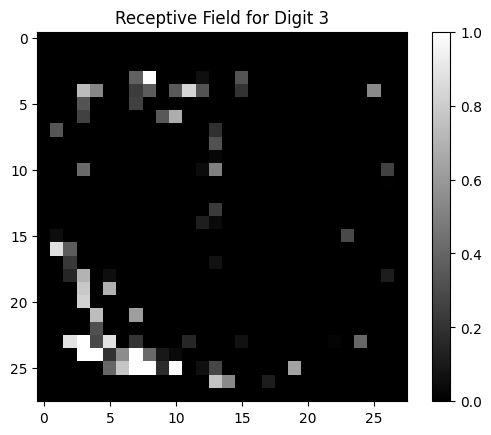

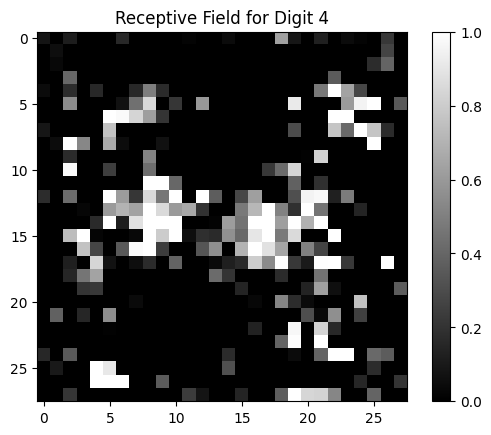

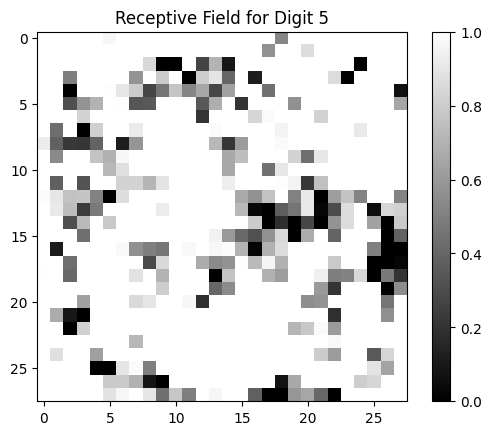

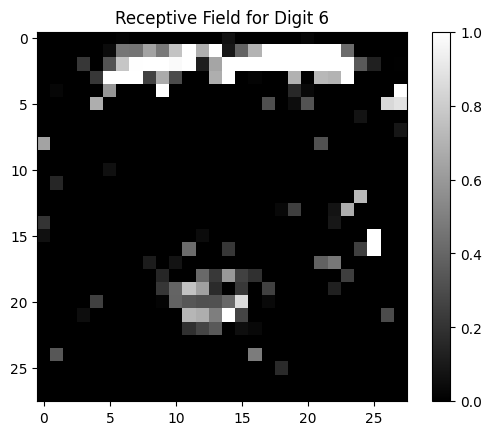

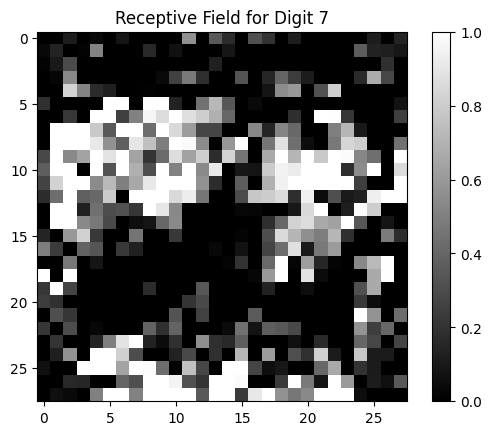

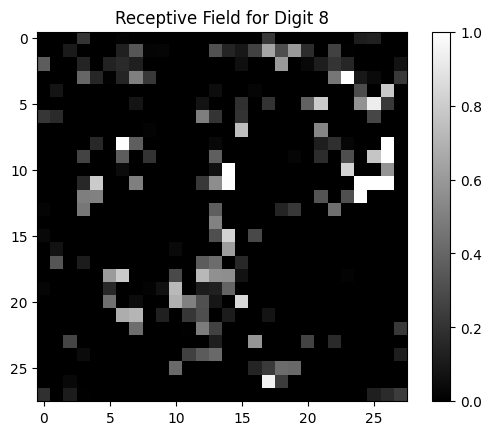

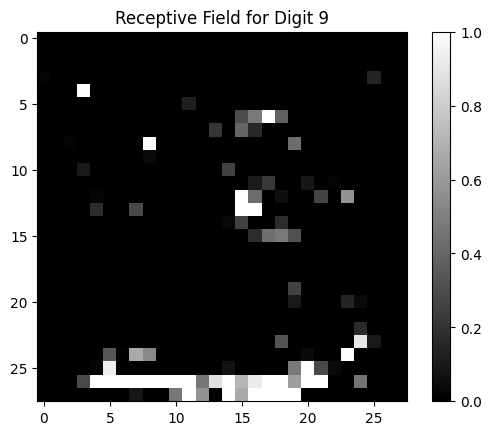

In [16]:
import numpy as np

# your code start from here for step 13

def print_receptive_field(model, digit=0):
    # one of the best ways to understand an ai is to see some visuals!
    # this prints an estimate for the FEATURE IMPORTANCE for each individual input pixel in each output

    populated_image = np.zeros(shape=(28,28), dtype=np.float32)
    
    generate_image = np.zeros(shape=(1,28,28,1), dtype=np.float32)
    for x in range(generate_image.shape[1]):
        for y in range(generate_image.shape[2]):
            # for each possible pixel in the input
            # set it to 1
            generate_image[0,x,y,0] = 1

            output = model(generate_image, training=False)
            digit_output = output[0,digit]
            populated_image[x,y] = digit_output
            
            # reset the pixel back to zero before moving to the next iter
            generate_image[0,x,y,0] = 0

    plt.imshow(populated_image, cmap='gray', vmin=0, vmax=1)
    plt.title(f"Receptive Field for Digit {digit}")
    plt.colorbar()
    plt.show()

def print_receptive_fields(model):
    for digit in range(10):
        print_receptive_field(model, digit)

print("===============================Teacher=================================")
print_receptive_fields(cnn_model)
print("===============================Student=================================")
print_receptive_fields(fc_model)
print("===============================Student Without Distillation=================================")
print_receptive_fields(fc_model_no_distillation)
